In [1]:
!pip install opencv-python-headless

In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab.patches import cv2_imshow

In [3]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [37]:
img = cv2.imread('img2.jpg')

In [38]:
def preprocess_image(image):
    """
    입력: RGB/BGR 이미지
    출력: 전처리가 완료된 이진화 이미지(binary), 중간에 필요한 결과도 반환해도 좋음
    """
    # 1. 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. 노이즈 제거 및 엣지 보존
    gray = cv2.bilateralFilter(gray, 5, 30, 30)

    # 3. 대비 향상
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15,15))
    gray = clahe.apply(gray)

    # 4. 이진화 (Otsu's Thresholding)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 5. 모폴로지 연산 (노이즈 제거)
    kernel = np.ones((3, 3), np.uint8)

    # 4가지 모폴로지 연산 수행
    morphology_results = {
        'Erosion': cv2.erode(binary, kernel, iterations=1),
        'Dilation': cv2.dilate(binary, kernel, iterations=1),
        'Opening': cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel),
        'Closing': cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    }

    # 6. Canny 엣지 검출
    edges_results = {name: cv2.Canny(morph, 100, 200)
                    for name, morph in morphology_results.items()}

    return gray, binary, morphology_results, edges_results

# 전처리 테스트
if img is not None:
    # 전처리 수행
    gray, binary, morphology_results, edges_results = preprocess_image(img)

    # # 결과 시각화
    # plt.figure(figsize=(15, 10))

    # # 원본 이미지
    # plt.subplot(3, 4, 1)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.title('Original')

    # # 그레이스케일
    # plt.subplot(3, 4, 2)
    # plt.imshow(gray, cmap='gray')
    # plt.title('Grayscale')

    # # 이진화
    # plt.subplot(3, 4, 3)
    # plt.imshow(binary, cmap='gray')
    # plt.title('Binary')

    # # 각 모폴로지 연산 결과
    # for idx, (name, result) in enumerate(morphology_results.items(), 4):
    #     plt.subplot(3, 4, idx)
    #     plt.imshow(result, cmap='gray')
    #     plt.title(f'After {name}')

    # # 각 Canny 엣지 결과
    # for idx, (name, edges) in enumerate(edges_results.items(), 8):
    #     plt.subplot(3, 4, idx)
    #     plt.imshow(edges, cmap='gray')
    #     plt.title(f'Canny after {name}')

    # plt.tight_layout()
    # plt.show()

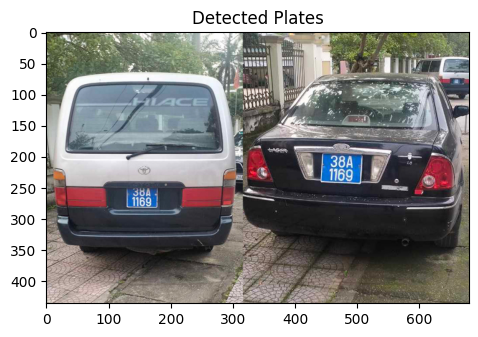

In [56]:
def detect_plate_areas(image, binary_image):
    plates = []
    plate_coords = []

    # 노이즈 제거 및 이미지 개선
    kernel = np.ones((3,3), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(
        binary_image,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # 이미지의 왼쪽 절반만 검사
    image_center_x = image.shape[1] // 2

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # 왼쪽 영역에 있는 컨투어만 처리
        if x < image_center_x:
            area = w * h
            aspect_ratio = w / h

            # 번호판 특성에 맞게 조건 조정
            if (2.0 < aspect_ratio < 3.5 and    # 번호판 비율 조정
                3000 < area < 12000 and         # 면적 범위 조정
                30 < h < 70 and                 # 높이 범위 조정
                80 < w < 200 and                # 너비 범위 조정
                y > image.shape[0]/2):          # 하단부 검색

                roi = image[y:y+h, x:x+w]
                gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                # 번호판 특성 검사
                mean_val = np.mean(gray_roi)
                std_val = np.std(gray_roi)

                # 파란색 영역 검사 (번호판 배경)
                hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
                blue_mask = cv2.inRange(hsv_roi,
                                      np.array([100,50,50]),
                                      np.array([130,255,255]))
                blue_ratio = np.sum(blue_mask > 0) / (w * h)

                if (std_val > 35 and            # 대비 조건 완화
                    45 < mean_val < 200 and     # 밝기 범위 확대
                    blue_ratio > 0.2):          # 파란색 비율 조건 조정
                    plates.append(roi)
                    plate_coords.append((x,y,w,h))

    return plates, plate_coords




if img is not None:
    gray, binary, morphology_results, edges_results = preprocess_image(img)
    detected_plates, coords = detect_plate_areas(img, binary)

    img_copy = img.copy()
    for i, (x, y, w, h) in enumerate(coords):
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title('Detected Plates')

    if len(detected_plates) > 0:
        plt.subplot(1, 2, 2)
        plt.imshow(detected_plates[0])
        plt.title('Sample Plate')
    plt.show()

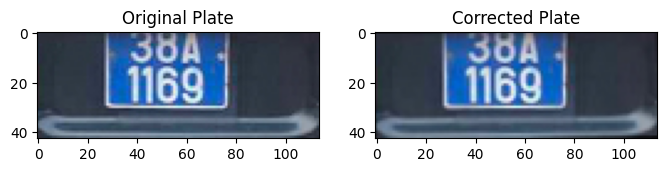

In [47]:
def correct_skew(plate_img):
    """
    입력: 번호판 이미지
    출력: 기울기/왜곡이 보정된 번호판 이미지
    """
    src = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    m = cv2.moments(src)
    angle = 0.5 * np.arctan2(2*m['mu11'], abs(m['mu02']-m['mu20'])) * 180 / np.pi
    center = (plate_img.shape[1] // 2, plate_img.shape[0] // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_out = cv2.warpAffine(plate_img, M, (plate_img.shape[1], plate_img.shape[0]))

    return img_out

# 간단 테스트
if img is not None:
    if len(detected_plates) > 0:
        test_plate = detected_plates[0]
        fixed_plate = correct_skew(test_plate)

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(test_plate, cv2.COLOR_BGR2RGB))
        plt.title('Original Plate')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(fixed_plate, cv2.COLOR_BGR2RGB))
        plt.title('Corrected Plate')
        plt.show()

In [48]:
gauss = cv2.GaussianBlur(test_plate, (5,5), 0)

In [49]:
pixel_values = processor(images=gauss, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

LNOSI


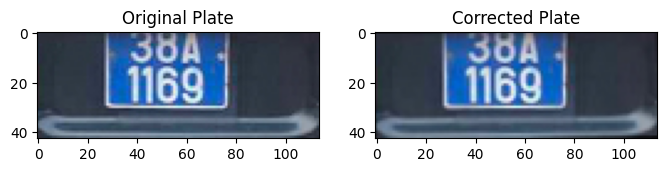

In [50]:
print(generated_text)
# 간단 테스트
if img is not None:
    if len(detected_plates) > 0:
        test_plate = detected_plates[0]
        fixed_plate = correct_skew(test_plate)

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(test_plate, cv2.COLOR_BGR2RGB))
        plt.title('Original Plate')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(fixed_plate, cv2.COLOR_BGR2RGB))
        plt.title('Corrected Plate')
        plt.show()